In [1]:
# Full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os
import subprocess
import pickle 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# 
from lib_modeling import *
from lib_feature_engineering import *

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

# Load combined features + label

In [4]:
pdf_features_label = pd.read_csv(os.path.join("features", "pdf_features_label.csv.bz2"), compression="bz2")
pdf_train = pdf_features_label.query("tvt_code == 'train'")
meta_cols = ["SK_ID_CURR", "TARGET", "tvt_code"]
ls_features = [cname for cname in pdf_features_label.columns if cname not in meta_cols]

# 
print("Number of features: {}".format(len(ls_features)))
print("pdf_features_label: {}".format(pdf_features_label.shape))
print("pdf_train: {}".format(pdf_train.shape))

Number of features: 1042
pdf_features_label: (356255, 1045)
pdf_train: (216948, 1045)


# Load feature important

In [5]:
# read model
version = "v07"
with open("../05_modeling/models/xgb_model_{}.mod".format(version), "rb") as input_file:
    res_model = pickle.load(input_file)
res_model.keys()

['auc',
 'ls_tracked_auc',
 'ls_curr_features',
 'imp',
 'ls_tracked_imp',
 'model',
 'features']

In [6]:
# load most important feature set
pdf_imp = pd.DataFrame(res_model["imp"])
pdf_imp.rename(columns= {0: "feat_name", 1: "F-score"}, inplace=True) 
pdf_imp.set_index("feat_name", inplace=True)
pdf_imp.head()

,F-score
feat_name,
prev_app_NAME_PRODUCT_TYPE_walk_in_max,162.8774
baseline_extend_EXT_SOURCE_2,126.3244
baseline_extend_EXT_SOURCE_3,117.8964
bureau_CREDIT_DAY_OVERDUE_TO_YEARS_median,97.5458
NAME_EDUCATION_TYPE_Higher_education,77.9346


In [7]:
# analyse tracking important features
ls_imp = []
for track in res_model["ls_tracked_imp"]:
    imp = pd.DataFrame(track)
    imp.rename(columns= {0: "feat_name", 1: "imp"}, inplace=True) 
    ls_imp.append(imp)
pdf_analysis = pd.concat(ls_imp).groupby("feat_name").agg({"imp": ["max", "min", "mean", "std"], "feat_name": "count"})

# rename columns
name01 = pdf_analysis.columns.get_level_values(0)
name02 = pdf_analysis.columns.get_level_values(1)
rename_cols = ["{}_{}".format(tpl[0], tpl[1]) for tpl in zip(name01, name02)]
rename_cols[-1] = "num_chosen_by_model"
pdf_analysis.columns = rename_cols
pdf_analysis = pdf_analysis.sort_values(by="imp_max", ascending=False)

In [8]:
# get top features
pdf_analysis.head()

,imp_max,imp_min,imp_mean,imp_std,num_chosen_by_model
feat_name,,,,,
prev_app_NAME_PRODUCT_TYPE_walk_in_max,162.8774,71.1525,117.0150,64.8593,2
baseline_extend_EXT_SOURCE_2,127.9498,124.9303,126.4015,1.5112,3
baseline_extend_EXT_SOURCE_3,123.9631,108.6327,116.8307,7.7206,3
bureau_CREDIT_DAY_OVERDUE_TO_YEARS_median,97.5458,13.5619,55.5538,59.3855,2
NAME_EDUCATION_TYPE_Higher_education,78.8431,73.9365,76.9047,2.6104,3


In [9]:
# get tail features
pdf_analysis.tail()

,imp_max,imp_min,imp_mean,imp_std,num_chosen_by_model
feat_name,,,,,
bureau_balance_lt1year_STATUS_Sold_sum_median,7.3072,7.3072,7.3072,NaN,1
pos_cash_gt3year_is_DPD_DEF_max,5.9348,5.9348,5.9348,NaN,1
is_REG_REGION_NOT_LIVE_REGION,5.1233,5.1233,5.1233,NaN,1
ORGANIZATION_TYPE_Other,5.1182,5.1182,5.1182,NaN,1
bureau_balance_STATUS_Sold_sum_std,3.5234,3.5234,3.5234,NaN,1


# Analysis

In [10]:
def plot_distribution_over_target(pdf_input, cname):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    #
    pdf_input.groupby("TARGET")[cname].plot(kind='kde', ax=axes[0], rot=45)
    pdf_input.groupby("TARGET")[cname].hist(bins=100, ax=axes[1], xrot=45)
    pdf_input.boxplot(column=cname, by='TARGET', ax=axes[2])
    
    #
    plt.suptitle("Distribution of {} (0: blue, 1: red)".format(cname))
    plt.show()
    
def my_auc(y_score, y_true, flexible_sign=True):
    # filter NaN
    idx = np.isfinite(y_score)
    xxx = y_score[idx]
    yyy = y_true[idx]

    # if label not only 1s/0s
    if yyy.std() > 0.0:
        auc = metrics.roc_auc_score(y_score=xxx, y_true=yyy)
    else:
        auc = 0.5

    # for evaluation only
    if (auc < 0.5) & (flexible_sign):
        auc = 1.0 - auc
    return auc

def feature_evaluate(pdf_feat_label, ls_feat=None):
    out_res = {
        "feat_name": [],
        "auc": [],
        "corr": [],
        "coverage": []
    }

    # calculate correlation
    pdf_corr = pdf_feat_label[["TARGET"] + ls_feat].corr()

    for feat in ls_feat:
        out_res["feat_name"].append(feat)
        out_res["auc"].append(my_auc(pdf_feat_label[feat], pdf_feat_label["TARGET"]))
        out_res["corr"].append(pdf_corr.loc[feat, "TARGET"])
        out_res["coverage"].append((~pdf_feat_label[feat].isna()).mean())

    #
    pdf_res = pd.DataFrame(out_res)
    pdf_res = pdf_res[["feat_name", "auc", "corr", "coverage"]].sort_values(by="auc", ascending=False)
    pdf_res.set_index("feat_name", inplace=True)
    return pdf_res

In [11]:
ls_feat = ["prev_app_NAME_PRODUCT_TYPE_walk_in_max", "baseline_extend_EXT_SOURCE_2", "credit_card_balance_AMT_DRAWINGS_CURRENT_min"]
pdf_eval01 = feature_evaluate(pdf_train, ls_feat=ls_feat)
pdf_eval01 = pdf_analysis.join(pdf_eval01, how="inner")
pdf_eval01

,imp_max,imp_min,imp_mean,imp_std,num_chosen_by_model,auc,corr,coverage
feat_name,,,,,,,,
prev_app_NAME_PRODUCT_TYPE_walk_in_max,162.8774,71.1525,117.0150,64.8593,2,0.5468,0.0595,0.9467
baseline_extend_EXT_SOURCE_2,127.9498,124.9303,126.4015,1.5112,3,0.6559,-0.1602,0.9978
credit_card_balance_AMT_DRAWINGS_CURRENT_min,10.4587,6.8901,8.2056,1.9604,3,0.5124,0.0158,0.2824


# AUC

Seperate càng cao thì càng tốt 

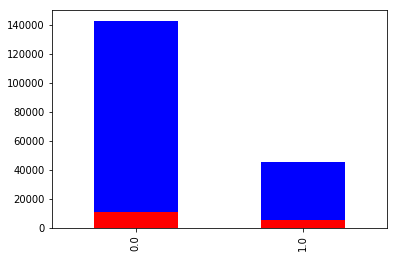

In [12]:
pdf0 = pdf_train.query("TARGET == 0")
pdf1 = pdf_train.query("TARGET == 1")

fig, ax = plt.subplots()
pdf0["prev_app_NAME_PRODUCT_TYPE_walk_in_max"].value_counts().plot(kind="bar", ax=ax, color="blue")
pdf1["prev_app_NAME_PRODUCT_TYPE_walk_in_max"].value_counts().plot(kind="bar", ax=ax, color="red")
plt.show()

,imp_max,imp_min,imp_mean,imp_std,num_chosen_by_model,auc,corr,coverage
baseline_extend_EXT_SOURCE_2,127.9498,124.9303,126.4015,1.5112,3.0,0.6559,-0.1602,0.9978


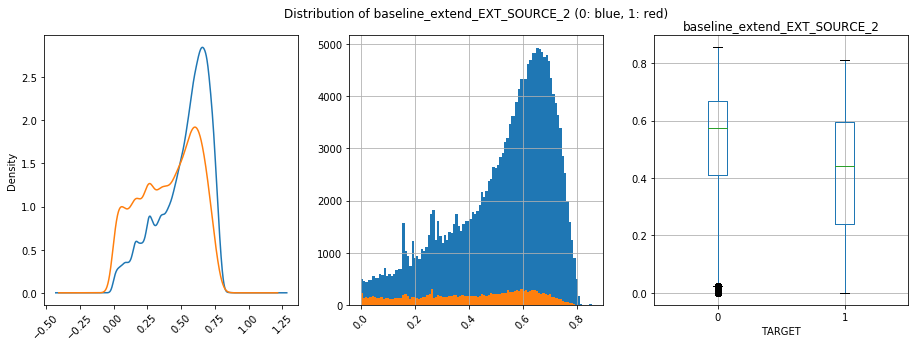

In [13]:
attr = "baseline_extend_EXT_SOURCE_2"
display(pdf_eval01.loc[attr].to_frame().T)
plot_distribution_over_target(pdf_train, attr)

,imp_max,imp_min,imp_mean,imp_std,num_chosen_by_model,auc,corr,coverage
credit_card_balance_AMT_DRAWINGS_CURRENT_min,10.4587,6.8901,8.2056,1.9604,3.0,0.5124,0.0158,0.2824


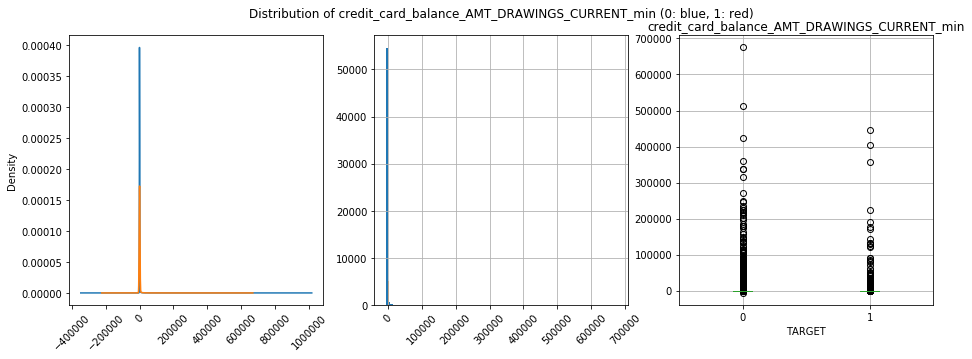

In [14]:
attr = "credit_card_balance_AMT_DRAWINGS_CURRENT_min"
display(pdf_eval01.loc[attr].to_frame().T)
plot_distribution_over_target(pdf_train, attr)

# Correlation

Tương quan càng cao càng tốt

In [15]:
pdf_train[["TARGET", "baseline_extend_EXT_SOURCE_2", "credit_card_balance_AMT_DRAWINGS_CURRENT_min"]].corr()

,TARGET,baseline_extend_EXT_SOURCE_2,credit_card_balance_AMT_DRAWINGS_CURRENT_min
TARGET,1.0000,-0.1602,0.0158
baseline_extend_EXT_SOURCE_2,-0.1602,1.0000,-0.0081
credit_card_balance_AMT_DRAWINGS_CURRENT_min,0.0158,-0.0081,1.0000


# Coverage

Null càng ít càng tốt

In [16]:
pdf_train["baseline_extend_EXT_SOURCE_2"].isna().mean()

0.0022217305529435624

In [17]:
pdf_train["credit_card_balance_AMT_DRAWINGS_CURRENT_min"].isna().mean()

0.717600531002821